<a href="https://colab.research.google.com/github/hemanth346/eva4/blob/master/S7/S7_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Target :

- change the architecture to C1C2C3C40 (basically 3 MPs)
- total RF must be more than 44
- one of the layers must use Depthwise Separable Convolution
- one of the layers must use Dilated Convolution
- use GAP (compulsory):- add FC after GAP to target #of classes (optional)
- achieve 80% accuracy, as many epochs as you want. Total Params to be less than 1M. 



In [0]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from __future__ import print_function
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

from IPython.display import Image # to display PIL images
import matplotlib.pyplot as plt
%matplotlib inline

!pip install torchsummary

In [3]:
import os
import sys
import os.path as Path

# mount gdrive and unzip data
try:
  from google.colab import drive
  drive.mount('/content/gdrive')
  trainer = '/content/gdrive/My Drive/Pytorch/'
  sys.path.insert(0, Path.abspath(trainer))
  print('Added to sys path')
except:
  code_dir = '.'
print('Path : ',Path.abspath(trainer))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Added to sys path
Path :  /content/gdrive/My Drive/Pytorch


In [4]:
import numpy as np
## Get mean and std
simple_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       ])
exp = datasets.CIFAR10('./data', train=True, download=True, transform=simple_transforms)
# print(exp, type(exp))
exp_data = exp.data # https://github.com/lyakaap/VAT-pytorch/issues/9
exp_data = exp_data/255.
print('[Train]')
# print(' - Type :', type(exp_data))
print(' - Numpy Shape:', exp_data.shape)
print(' - min:', np.min(exp_data))
print(' - max:', np.max(exp_data))
mean = np.mean(exp_data, axis=(0,1,2))
std = np.std(exp_data, axis=(0,1,2))
var = np.var(exp_data, axis=(0,1,2))
mean, std = tuple(np.round(mean, 3)) ,tuple(np.round(std, 3))
print(' - mean:', mean)
print(' - std:', std)
print(' - var:', var)


Files already downloaded and verified
[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - min: 0.0
 - max: 1.0
 - mean: (0.491, 0.482, 0.447)
 - std: (0.247, 0.243, 0.262)
 - var: [0.06102492 0.05928501 0.0684282 ]


In [5]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                    #    transforms.Resize((32, 32)), # all the data is already in this shape
                                       transforms.ToTensor() ,
                                       transforms.Normalize(mean, std) 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean, std)
                                       ])
# # dataset - Creating train and test
train_data = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


cuda = torch.cuda.is_available()
print('Cuda : ', cuda)
# loaders
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
device = torch.device("cuda" if cuda else "cpu")

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader   
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)


Files already downloaded and verified
Files already downloaded and verified
Cuda :  True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


truck horse  ship  bird  bird


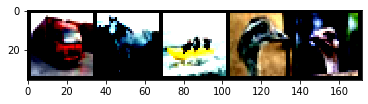

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
visualize_train_loader = torch.utils.data.DataLoader(train_data, batch_size=5,shuffle=True )
dataiter = iter(visualize_train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(5)))


## Model

In [0]:
def conv_block(in_channels, out_channels, dropout=0, *args, **kwargs):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, *args, **kwargs),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Dropout(dropout)
        )
def depthwise_separable_conv(in_channels, out_channels, dropout=0,*args, **kwargs):
    # https://discuss.pytorch.org/t/depthwise-and-separable-convolutions-in-pytorch/7315/2?u=hemanth346
    self.depthwise = nn.Conv2d(in_channels, in_channels*kernels_per_layer, groups=in_channels)
    self.pointwise = nn.Conv2d(in_channels*kernels_per_layer, out_channels, kernel_size=1)
    

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv01 = nn.Conv2d(3, 16, 3, bias=False, padding=1)        #O=32
        self.batch01 = nn.BatchNorm2d(num_features=16)    
        self.conv02 = nn.Conv2d(16, 16, 3, bias=False,padding=1)        #O=28
        self.batch02 = nn.BatchNorm2d(num_features=16)    
        self.conv03 = nn.Conv2d(16, 16, 3, bias=False,padding=1)        #O=28
        self.batch03 = nn.BatchNorm2d(num_features=16)   
        self.conv04 = nn.Conv2d(16, 16, 3, bias=False,padding=1)        #O=26
        self.batch04 = nn.BatchNorm2d(num_features=16)   
        self.pool01 = nn.MaxPool2d(2, 2)                                #O=16
        self.conv05 = nn.Conv2d(16, 16, 1, bias=False)

        self.conv11 = nn.Conv2d(16, 32, 3, bias=False, padding=1)       #O=
        self.batch11 = nn.BatchNorm2d(num_features=32)
        self.conv12 = nn.Conv2d(32, 32, 3, bias=False, padding=1)       #O=
        self.batch12 = nn.BatchNorm2d(num_features=32)
        self.conv13 = nn.Conv2d(32, 32, 3, bias=False, padding=1)       #O=
        self.batch13 = nn.BatchNorm2d(num_features=32)
        self.conv14 = nn.Conv2d(32, 32, 3, bias=False, padding=1)       #O=
        self.batch14 = nn.BatchNorm2d(num_features=32)
        self.pool11 = nn.MaxPool2d(2, 2)                                #O=8
        self.conv15 = nn.Conv2d(32, 32, 1, bias=False)

        self.conv21 = nn.Conv2d(32, 64, 3, bias=False, padding=1)       #O=
        self.batch21 = nn.BatchNorm2d(num_features=64)
        self.conv22 = nn.Conv2d(64, 64, 3, bias=False, padding=1)       #O=
        self.batch22 = nn.BatchNorm2d(num_features=64)
        self.conv23 = nn.Conv2d(64, 64, 3, bias=False, padding=1)       #O=
        self.batch23 = nn.BatchNorm2d(num_features=64)
        self.conv24 = nn.Conv2d(64, 64, 3, bias=False, padding=1)       #O=
        self.batch24 = nn.BatchNorm2d(num_features=64)
        self.pool21 = nn.MaxPool2d(2, 2)                                #O=4
        self.conv25 = nn.Conv2d(64, 32, 1, bias=False)

        self.conv31 = nn.Conv2d(32, 64, 3, bias=False, padding=1)       #O=05
        self.batch31 = nn.BatchNorm2d(num_features=64)
        self.conv32 = nn.Conv2d(64, 64, 3, bias=False, padding=1)       #O=05
        self.batch32 = nn.BatchNorm2d(num_features=64)
        self.conv33 = nn.Conv2d(64, 64, 3, bias=False, padding=1)       #O=05
        self.batch33 = nn.BatchNorm2d(num_features=64)
    
        self.avg_pool = nn.AvgPool2d(kernel_size=4)
        self.convx3 = nn.Conv2d(64, 10, 1, bias=False, padding=0)

    def forward(self, x):
        x = self.batch01(F.relu(self.conv01(x)))        
        x = self.batch02(F.relu(self.conv02(x)))
        x = self.batch03(F.relu(self.conv03(x)))
        x = self.batch04(F.relu(self.conv04(x)))
        x = self.pool01(x)
        x = self.conv05(x)

        x = self.batch11(F.relu(self.conv11(x)))
        x = self.batch12(F.relu(self.conv12(x)))
        x = self.batch13(F.relu(self.conv13(x)))
        x = self.batch14(F.relu(self.conv14(x)))
        x = self.pool11(x)
        x = self.conv15(x)

        x = self.batch21(F.relu(self.conv21(x)))
        x = self.batch22(F.relu(self.conv22(x)))
        x = self.batch23(F.relu(self.conv23(x)))
        x = self.batch24(F.relu(self.conv24(x)))
        x = self.pool21(x)
        x = self.conv25(x)

        x = self.batch31(F.relu(self.conv31(x)))
        x = self.batch32(F.relu(self.conv32(x)))
        x = self.batch33(F.relu(self.conv33(x)))


        x = self.avg_pool(x)
        x = self.convx3(x)
        x = x.view(-1, 10)                           # Don't want 10x1x1..
        return F.log_softmax(x)

In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
from engine.trainer import Model
model = Model(Net())

In [10]:
model.summary(input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]           2,304
       BatchNorm2d-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
            Conv2d-7           [-1, 16, 32, 32]           2,304
       BatchNorm2d-8           [-1, 16, 32, 32]              32
         MaxPool2d-9           [-1, 16, 16, 16]               0
           Conv2d-10           [-1, 16, 16, 16]             256
           Conv2d-11           [-1, 32, 16, 16]           4,608
      BatchNorm2d-12           [-1, 32, 16, 16]              64
           Conv2d-13           [-1, 32, 16, 16]           9,216
      BatchNorm2d-14           [-1, 32,

In [11]:
optimizer = optim.SGD(Net().parameters(), lr=0.001, momentum=0.9)
model.compile(optimizer=optimizer, loss='nll_loss')

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
) nll_loss 0


In [15]:
for epoch in range(10):
    print(f'Epoch  : {epoch}')
    model.train(train_loader)
    model.eval(test_loader)
    # model.epochs += 1

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch  : 0


Loss=2.2773115634918213 Batch_id=390 Accuracy=10.23: 100%|██████████| 391/391 [00:16<00:00, 24.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 2.3151, Accuracy: 983/10000 (9.83%)

Epoch  : 1


Loss=2.3410439491271973 Batch_id=390 Accuracy=10.12: 100%|██████████| 391/391 [00:15<00:00, 24.57it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 2.3149, Accuracy: 1011/10000 (10.11%)

Epoch  : 2


Loss=2.299898624420166 Batch_id=390 Accuracy=9.99: 100%|██████████| 391/391 [00:15<00:00, 24.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 2.3147, Accuracy: 1020/10000 (10.20%)

Epoch  : 3


Loss=2.3154752254486084 Batch_id=390 Accuracy=9.99: 100%|██████████| 391/391 [00:15<00:00, 30.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 2.3145, Accuracy: 1001/10000 (10.01%)

Epoch  : 4


Loss=2.313582420349121 Batch_id=390 Accuracy=10.04: 100%|██████████| 391/391 [00:15<00:00, 24.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 2.3152, Accuracy: 1013/10000 (10.13%)

Epoch  : 5


Loss=2.327085256576538 Batch_id=390 Accuracy=9.94: 100%|██████████| 391/391 [00:15<00:00, 24.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 2.3154, Accuracy: 973/10000 (9.73%)

Epoch  : 6


Loss=2.3203797340393066 Batch_id=390 Accuracy=10.22: 100%|██████████| 391/391 [00:15<00:00, 24.71it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 2.3154, Accuracy: 1001/10000 (10.01%)

Epoch  : 7


Loss=2.2929155826568604 Batch_id=390 Accuracy=10.19: 100%|██████████| 391/391 [00:16<00:00, 23.76it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 2.3148, Accuracy: 996/10000 (9.96%)

Epoch  : 8


Loss=2.344651937484741 Batch_id=390 Accuracy=10.11: 100%|██████████| 391/391 [00:16<00:00, 23.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 2.3145, Accuracy: 982/10000 (9.82%)

Epoch  : 9


Loss=2.311802864074707 Batch_id=390 Accuracy=10.15: 100%|██████████| 391/391 [00:15<00:00, 24.57it/s]



Test set: Average loss: 2.3148, Accuracy: 1025/10000 (10.25%)



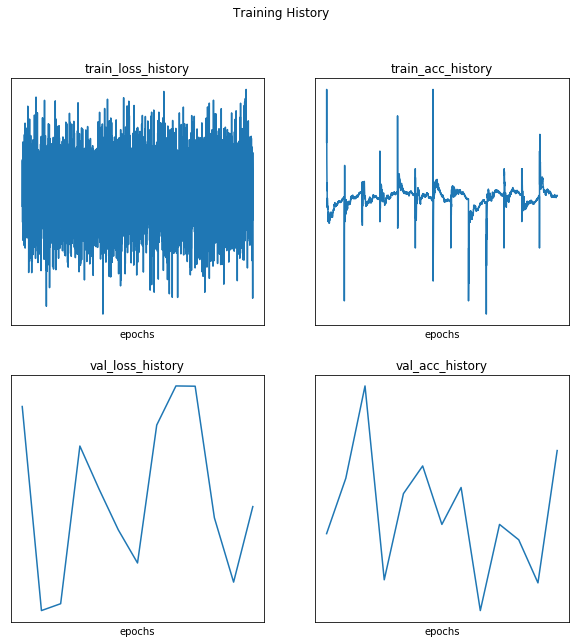

In [16]:
model.plot_history()

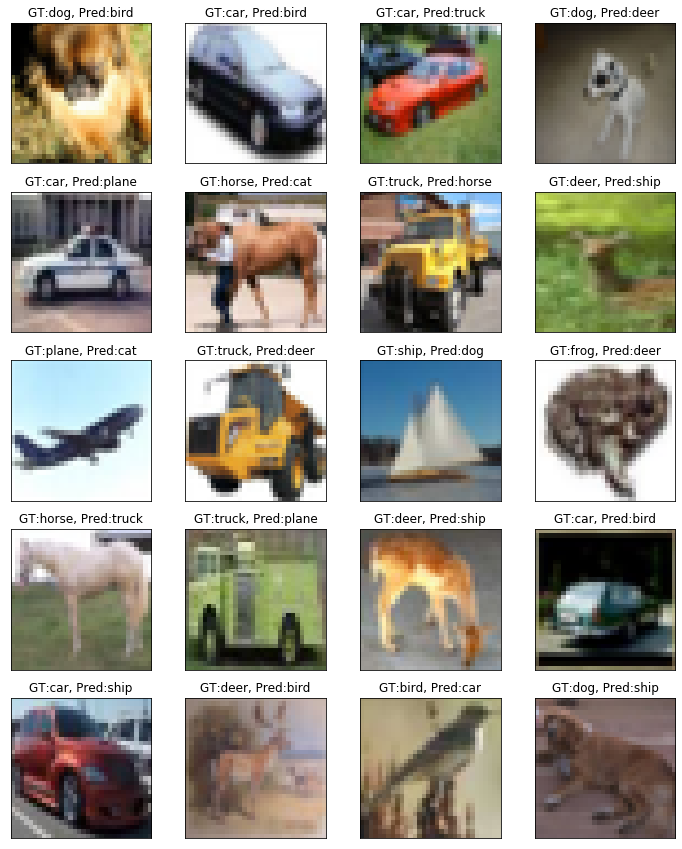

In [17]:
model.plot_misclassified(test_loader, labels=classes, mean=mean, std=std)